In [1]:
import numpy as np
import matplotlib.pyplot as plt
from general_functions import *
from scipy.integrate import solve_ivp
import matplotlib.cm as cm

In [34]:
N, S, M, lambd = 3, 3, 3, 0.01
trendsetter = 0
meaning_swapped = 0
signal_swapped = 2

def run_model_trendsetter(N=2, S=3, M=3, lambd=0.01, max_steps=1_000_000, wait_time=5000, threshold=0.8, anim=True):

    ladder_method = 'trendsetter'

    mu_pos, mu_neg = lambd, -lambd
    A_list, timesteps = [], []
    social_ladder = list(range(N))

    trendsetter = social_ladder[0]
    wait_counter = 0

    phi = initiate_phi(N, S, M, method='hazy_diagonal')

    if anim:

        # initialise animation
        fig, axs = plt.subplots(ncols=N, figsize=(N*2,3))
        fig.suptitle(f'$\lambda = {lambd}$, trendsetter 5, rest 0.1')
        for i in range(N): 
            axs[i].imshow(phi[i,:,:], interpolation='nearest', animated=True, cmap='magma', vmin=0, vmax=1)
            if i == trendsetter: axs[i].set_title('trendsetter')
            else:                axs[i].set_title('')


    for step in range(max_steps):

        speaker, listener = choose_agents(N)
        intend = choose_meaning(M)
        signal = choose_signal(S, prob_array=phi[speaker,:,intend])

        if speaker == trendsetter and phi[speaker, signal, intend] > threshold: # and intend == trend_meaning
            
            wait_counter += 1

            if wait_counter % wait_time == 0: # wait time is over

                print('wait time is over')
                # above threshold, trendsetter swaps two pairings
                # choose other signal
                new_signal_list = list(range(S))
                new_signal_list.pop(signal)
                new_signal = np.random.choice(new_signal_list) # new signal, different to original one

                # phi[speaker, new_signal, intend], phi[speaker, signal, intend] = 1, 0
                # phi[speaker,:,intend] /= np.sum(phi[speaker,:,intend]) # normalise to ensure range [0,1]

                phi[speaker, [signal, new_signal], intend] = phi[speaker, [new_signal, signal], intend] # swap
                # new_signal now has the phi value of signal (above 0.8)
                # don't update the grammar? 
                continue          

        infer = infer_meaning(M, prob_array=phi[listener,signal,:] / np.sum(phi[listener,signal,:]))
        feedback = get_feedback(mu_pos, mu_neg, intend, infer, M, N, speaker, listener, method=None, social_ladder=social_ladder) # ladder_method

        phi[speaker,signal,intend] += feedback * U(phi[speaker,signal,intend])
        phi[speaker,:,intend] /= np.sum(phi[speaker,:,intend])

        if step % 2000 == 0 and step > 0:

            A = intelligibility(phi, N, S, M)
            print('timestep {:7d} -- A = {:.3f}'.format(step, A))
            A_list.append(A)
            timesteps.append(step)

            if anim:

                # animation
                plt.cla()
                for i in range(N): axs[i].imshow(phi[i,:,:], interpolation='nearest', animated=True, cmap='magma', vmin=0, vmax=1)
            
                plt.draw()
                plt.pause(0.0001)

            if equilibrium(phi, N, S, M, A=A, thresh_frac=0.95): 
                print('equilibrium reached')
                break

    # plot the intelligibility
    fig, ax = plt.subplots()
    ax.plot(timesteps, A_list, marker='x')
    ax.set_ylabel('intelligibility')
    ax.set_xlabel('timesteps')
    ax.set_title(f'$(N, S, M, \lambda) = ({N}, {S}, {M}, {lambd})$')

    plt.show()

def trendsetter_initialise_phis(N, S, M, method='hazy_diagonal', epsilon=0.5, diag_val=2/3):

    phi = initiate_phi(N, S, M, method=method, epsilon=epsilon, diag_val=diag_val)
    phi_swapped = phi.copy()
    phi_swapped[trendsetter, [0, signal_swapped], meaning_swapped] = phi_swapped[trendsetter, [signal_swapped, 0], meaning_swapped]
    return phi, phi_swapped

def run_model(phi_init, N, S, M, mu_pos, mu_neg, max_steps=200000):

    phi = phi_init
    A_list, timesteps = [], []

    for step in range(max_steps):

        speaker, listener = choose_agents(N)
        intend = choose_meaning(M)
        signal = choose_signal(S, prob_array=phi[speaker,:,intend])
        infer = infer_meaning(M, prob_array=phi[listener,signal,:] / np.sum(phi[listener,signal,:]))
        feedback = get_feedback(mu_pos, mu_neg, intend, infer, M)

        phi[speaker,signal,intend] += feedback * U(phi[speaker,signal,intend])
        phi[speaker,:,intend] /= np.sum(phi[speaker,:,intend])

        if step % 2000 == 0 and step > 0:

            A = intelligibility(phi, N, S, M)
            print('timestep {:7d} -- A = {:.3f}'.format(step, A))
            A_list.append(A)
            timesteps.append(step)

            if equilibrium(phi, N, S, M, A=A, thresh_frac=0.95): 
                print('equilibrium reached')
                break

    return timesteps, A_list

def run_deterministic_model(phi_init, N, S, M, mu, tf):

    A_list = []
    t_eval = np.arange(0, tf+1000, 1000)
    
    y0 = phi_to_y(phi_init, N=N, S=S, M=M)
    sol = solve_ivp(deterministic_func, t_span=[0, tf], t_eval=t_eval, y0=y0, method='RK45', vectorized=True, args=(mu, N, M, S))
    
    for i in range(len(t_eval)):
        
        phi = y_to_phi(sol.y[:,i], N=N, S=S, M=M)
        A_list.append(intelligibility(phi, N, S, M))
    
    As = np.array(A_list)
    return As[As < 0.99], t_eval[As < 0.99]

def compare_swap(N, S, M, lambd, max_steps=200000, epsilon=1/3):
    
    phi, phi_swapped = trendsetter_initialise_phis(N, S, M, epsilon=epsilon)
    mu_pos, mu_neg = lambd, -lambd

    fig, axs = plt.subplots(ncols=N, nrows=2, tight_layout=True)
    for i in range(N): axs[0,i].matshow(phi[i,:,:], interpolation='nearest', cmap='magma', vmin=0, vmax=1)
    for i in range(N): axs[1,i].matshow(phi_swapped[i,:,:], interpolation='nearest', cmap='magma', vmin=0, vmax=1)
    axs[0,0].set_title('no swap', loc='left')
    for s in range(S):
        for m in range(M):
            axs[0,0].text(m, s, f'{phi[0,s,m]:.2f}', ha='center', va='center', color='white')
    axs[1,0].set_title('with swap', loc='left')

    fig, ax = plt.subplots()
    
    timesteps, A_list = run_model(phi, N, S, M, mu_pos, mu_neg, max_steps=max_steps)
    ax.plot(timesteps, A_list, label='no swap', color='b', alpha=0.5)

    timesteps, A_list = run_model(phi_swapped, N, S, M, mu_pos, mu_neg, max_steps=max_steps)
    ax.plot(timesteps, A_list, label='with swap', color='r', alpha=0.5)
    
    ax.set_ylabel('intelligibility')
    ax.set_xlabel('timesteps')
    ax.set_title(f'$(N, S, M, \lambda) = ({N}, {S}, {M}, {lambd})$')
    ax.legend()

    plt.show()

def compare_swap_deterministic(N, S, M, lambd, tf=50000, epsilon=1/3):

    phi, phi_swapped = trendsetter_initialise_phis(N, S, M, epsilon=epsilon)
    mu = lambd

    fig, ax = plt.subplots()
    
    As, t_eval = run_deterministic_model(phi, N, S, M, mu, tf)
    ax.plot(t_eval, As, label='no swap', color='b', alpha=0.5)

    As, t_eval = run_deterministic_model(phi_swapped, N, S, M, mu, tf)
    ax.plot(t_eval, As, label='with swap', color='r', alpha=0.5)
    
    ax.set_ylabel('intelligibility')
    ax.set_xlabel('timesteps')
    ax.set_title(f'$(N, S, M, \lambda) = ({N}, {S}, {M}, {lambd})$')
    ax.legend()

    plt.show()

def compare_swap_deterministic_epsilons(N, S, M, lambd, tf=100000):

    # epsilons = np.linspace(0, 0.66, 10)
    # diag_vals = np.arange(0.4, 1., 0.05)

    diag_vals = [0.4, 0.6, 0.8, 0.9, 0.95, 0.97, 0.99]

    cmap = cm.get_cmap('jet')

    # generate a list of 10 colors in increasing warmth
    colors = [cmap(i) for i in range(0, 256, int(256/len(diag_vals)))]

    mu = lambd
    fig, ax = plt.subplots(figsize=(6,6))

    for i, diag_val in enumerate(diag_vals):

        print(f'diag val = {diag_val:.2f}')

        phi, phi_swapped = trendsetter_initialise_phis(N, S, M, method='diag_val', diag_val=diag_val)
        As, t_eval = run_deterministic_model(phi, N, S, M, mu, tf)
        ax.plot(t_eval, As, label=f'diag val = {diag_val:.2f}', color=colors[i], alpha=0.4)

        As, t_eval = run_deterministic_model(phi_swapped, N, S, M, mu, tf)
        ax.plot(t_eval, As, color=colors[i], alpha=0.4, ls='dotted')

    ax.set_ylabel('intelligibility')
    ax.set_xlabel('timesteps')
    ax.set_title(f'$(N, S, M, \lambda) = ({N}, {S}, {M}, {lambd})$')
    ax.legend()

    plt.show()

In [35]:
# compare_swap(N, S, M, lambd, epsilon=0.6)

In [36]:
# compare_swap_deterministic(N, S, M, lambd, epsilon=0.6)

diag val = 0.40
diag val = 0.60
diag val = 0.80
diag val = 0.90
diag val = 0.95
diag val = 0.97
diag val = 0.99


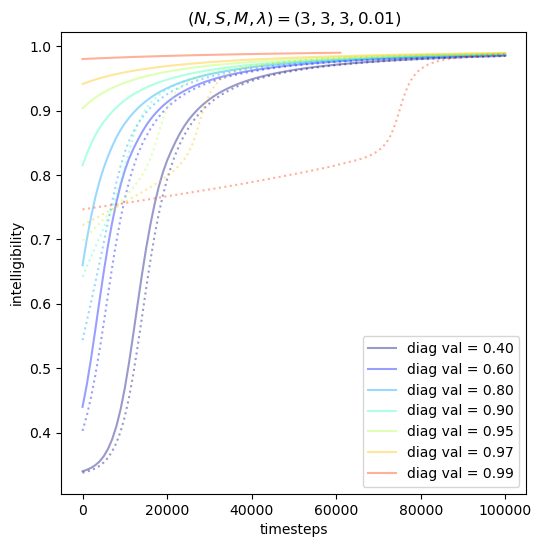

In [37]:
compare_swap_deterministic_epsilons(N, S, M, lambd)